### Smooth NDVI time series using entire dataset and peak preserving
Uses the full time series to despike and smooth NDVI while preserving peaks

#### Imports

In [2]:
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import tqdm
tqdm.pandas()
import time
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

In [3]:
#from importlib import reload
#import sys
#reload(sys.modules["tb_reed_params_smooth"])

In [9]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/params/co_wss_params/')
from co_wss_params_smooth import *

#### Helper functions

In [12]:
def adapt_smooth_ndvi(ts, dates, despike=True, dat_thresh=None, limit=91):
    ct_valid = sum(~np.isnan(ts[(dates.dt.month >= 5) & (dates.dt.month <= 10)]))
    ct_total = len(ts[(dates.dt.month >= 5) & (dates.dt.month <= 10)])
    avg_gap = ct_total/ct_valid
    if ct_valid > 0:
        if avg_gap > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts.values) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts.values
        if avg_gap > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=21, limit=limit)
        elif avg_gap > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=25, limit=limit)
        elif avg_gap > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=31, limit=limit)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=35, limit=limit)
    else:
        ts_smooth = ts
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

def full_smooth_ndvi(ts, dates):
    ndvi_min = ts[(dates.dt.month < 3) | (dates.dt.month > 10)].quantile(0.05)
    ts_ds = pd.Series(
        despike_ts(ts.values, dat_thresh=0.025, days_thresh=61)).interpolate(limit=None)
    ts_smooth = pd.Series(savgol_filter(ts_ds, 91, 3), index=ts.index)
    return ts_smooth

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# explore creating SOS
def calc_sos(ndvi_ts):
    if len(ndvi_ts) > 335:
        ndvi_thresh1 = np.nanpercentile(ndvi_ts[91:201], 40.0)
        date_thresh1 = next(x for x in np.where(ndvi_ts > ndvi_thresh1)[0] if x > 30)
        dndvi_ts = np.ones_like(ndvi_ts) * np.nan
        dndvi_ts[25:] = running_mean(np.diff(ndvi_ts), 25)
        dndvi_thresh2 = np.nanpercentile(dndvi_ts[:date_thresh1], 35.0)
        try:
            sos = np.where(dndvi_ts[:date_thresh1] < dndvi_thresh2)[0][-1]
            return sos
        except IndexError:
            return np.nan
    else:
        return np.nan

def weighted_ndvi(ndvi_smooth1, ndvi_smooth2, dates, days_max=90):
    pks = find_peaks(ndvi_smooth1, height=(0.25, None), prominence=(0.025, None))
    days_from_peak = dates.apply(lambda x: min(abs(x - dates.iloc[pks[0]])))
    weights1 = days_from_peak.dt.days.apply(lambda x: 0 if x > days_max else 1 - x/days_max)
    weights2 = 1.0 - weights1
    ndvi_wtd = np.average(np.array([ndvi_smooth1, ndvi_smooth2]), axis=0, weights=np.array([weights1, weights2]))
    return pd.Series(ndvi_wtd, index=ndvi_smooth1.index)

#### Prep data

In [13]:
fLIST = glob(inPATH_wc)
df = pd.concat([pd.read_csv(x, parse_dates=[1]) for x in fLIST]).reset_index(drop=True)

In [14]:
df

,Plot,time,NDVI,DFI,NDTI,SATVI,NDII7,SAVI,RDVI,MTVI1,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2
0,106_2013,2013-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,106_2013,2013-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106_2013,2013-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106_2013,2013-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106_2013,2013-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,90_2013,2013-11-29,0.228811,15.635693,0.143096,0.092280,0.077246,0.162197,15.421488,0.080057,...,124.820414,137.324277,125.116241,124.599289,910.923077,1329.076923,1790.307692,2845.923077,3179.153846,2371.769231
114,90_2013,2013-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,90_2013,2013-12-15,0.133692,17.903793,0.133364,-0.105422,0.280066,0.103158,9.786728,0.037052,...,120.241060,126.248577,122.543524,125.242249,1539.384615,1966.615385,2397.692308,3122.000000,2243.846154,1712.230769
116,90_2013,2013-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
if preprocess is not None:
    df = preprocess(df)

In [16]:
# drop dates where percent of pixels with na is above threshold
df = df[df['NA_pct'] < 0.25]

KeyError: 'NA_pct'

In [18]:
# rename columns to match ground data
df = df.rename(columns={'time': date_col,
                        'Plot': id_col}).sort_values([id_col, date_col])

In [312]:
#df[(df[id_col] == 'Mid Weiss G') & (df[date_col].dt.year == 2021)]

In [20]:
df

,Unique_ID,date,NDVI,DFI,NDTI,SATVI,NDII7,SAVI,RDVI,MTVI1,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2
0,106_2013,2013-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,106_2013,2013-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106_2013,2013-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106_2013,2013-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106_2013,2013-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,90_2013,2013-12-15,0.133692,17.903793,0.133364,-0.105422,0.280066,0.103158,9.786728,0.037052,...,120.241060,126.248577,122.543524,125.242249,1539.384615,1966.615385,2397.692308,3122.000000,2243.846154,1712.230769
60,90_2013,2013-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,90_2013,2013-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,90_2013,2013-12-31,0.203613,14.925406,0.127804,0.098840,0.022790,0.136878,13.022700,0.055804,...,132.425153,139.871498,133.240317,134.001141,853.153846,1232.384615,1650.692308,2491.384615,3044.000000,2346.230769


In [19]:
df.head(5)

,Unique_ID,date,NDVI,DFI,NDTI,SATVI,NDII7,SAVI,RDVI,MTVI1,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2
0,106_2013,2013-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,106_2013,2013-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106_2013,2013-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106_2013,2013-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106_2013,2013-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_out = None

#### Run initial smoothing

In [39]:
# get missing dates for gap-filling
dates_missing = [x for x in pd.date_range(df[date_col].min(), df[date_col].max()).date if x not in df[date_col].dt.date.unique()]

# convert missing dates to a dataframe for combining with veg index data
df_missing = pd.DataFrame({
    id_col: list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df[id_col].unique()])),
    date_col: list(chain.from_iterable(dates_missing for x in df[id_col].unique()))})

df_missing[date_col] = pd.to_datetime(df_missing[date_col])

# combine into one dataframe for gapfilling
df_ts = pd.concat([df, df_missing]).sort_values([id_col, date_col])

# apply Bolton mask to extracted values
if mask_bolton_by_id:
    ps_bolton = df_ts.groupby(id_col).progress_apply(lambda x: bolton_mask_np(x['BLUE'], x['SWIR2']))
    df.loc[df_ts[ps_bolton.droplevel(0) == 1.0].index, list(veg_dict.keys()) + band_list] = np.nan

# smooth all vegetation indices to gapfill
print('Smoothing NDVI')
df_ndvi = df_ts[[id_col, date_col, 'NDVI']].copy().sort_values([id_col, date_col]).reset_index(drop=True)
vals_smooth = df_ndvi.groupby(id_col).progress_apply(lambda x: adapt_smooth_ndvi(x['NDVI'], pd.to_datetime(x[date_col]), dat_thresh=0.05, limit=121))
if vals_smooth.index.nlevels > 1:
    df_ndvi.loc[:, 'NDVI_smooth'] = vals_smooth.droplevel(list(np.arange(vals_smooth.index.nlevels-1)))
else:
    df_ndvi.loc[:, 'NDVI_smooth'] = vals_smooth.values.squeeze()

Smoothing NDVI


100%|██████████| 3/3 [00:00<00:00, 205.46it/s]


In [34]:
df_ndvi.head(5)

,Unique_ID,date,NDVI,NDVI_smooth
0,106_2013,2013-04-19,NaN,0.224703
1,106_2013,2013-04-20,NaN,0.224703
2,106_2013,2013-04-21,NaN,0.224703
3,106_2013,2013-04-22,NaN,0.224703
4,106_2013,2013-04-23,NaN,0.224703


In [41]:
df_ndvi

,Unique_ID,date,NDVI,NDVI_smooth,NDVI_smooth2
0,106_2013,2013-04-19,NaN,0.224703,NaN
1,106_2013,2013-04-20,NaN,0.224703,NaN
2,106_2013,2013-04-21,NaN,0.224703,NaN
3,106_2013,2013-04-22,NaN,0.224703,NaN
4,106_2013,2013-04-23,NaN,0.224703,NaN
...,...,...,...,...,...
791,90_2013,2013-12-28,NaN,0.186954,0.179008
792,90_2013,2013-12-29,NaN,0.191322,0.180999
793,90_2013,2013-12-30,NaN,0.195640,0.183158
794,90_2013,2013-12-31,0.203613,0.199878,0.185489


#### Run secondary smoothing and calculate SOS

In [40]:
# run secondary smoothing on full time series
ndvi_ts_smooth = df_ndvi.groupby(id_col).apply(lambda x: full_smooth_ndvi(x['NDVI'], x[date_col]))
df_ndvi['NDVI_smooth2'] = ndvi_ts_smooth.droplevel(list(np.arange(ndvi_ts_smooth.index.nlevels-1)))

In [26]:
# # calculate start of season as DOY for each plot and year
# df_sos = df_ndvi.groupby([df_ndvi[date_col].dt.year, id_col])['NDVI_smooth2'].apply(
#     lambda x: calc_sos(x)).reset_index().rename(columns={'NDVI_smooth2': 'SOS_doy',
#                                                          date_col: 'Year'})
# # drop nan SOS values
# df_sos = df_sos.dropna(subset='SOS_doy')

# # change SOS_doy back to integer
# df_sos['SOS_doy'] = df_sos['SOS_doy'].astype(int)

# # get as date
# df_sos['SOS_date'] = df_sos.apply(lambda x: datetime(x['Year'], 1, 1) + timedelta(days=x['SOS_doy']), axis=1)

# # merge with NDVI for plotting
# df_sos = pd.merge(df_sos, df_ndvi[[date_col, id_col, 'NDVI_smooth2']], 
#          left_on=['SOS_date', id_col],
#          right_on=[date_col, id_col], how='left')

ValueError: Expected a 1D array, got an array with shape (0, 3)

In [37]:
# df_ndvi['Year'] = df_ndvi[date_col].dt.year

# # drop years with incomplete data from time series
# df_ndvi_yr_ct = df_ndvi.groupby([id_col, 'Year'])[date_col].transform(lambda x: len(x))
# df_ndvi = df_ndvi[df_ndvi_yr_ct > 330]

In [38]:
df_ndvi

,Unique_ID,date,NDVI,NDVI_smooth,NDVI_smooth2,Year


ValueError: attempt to get argmax of an empty sequence

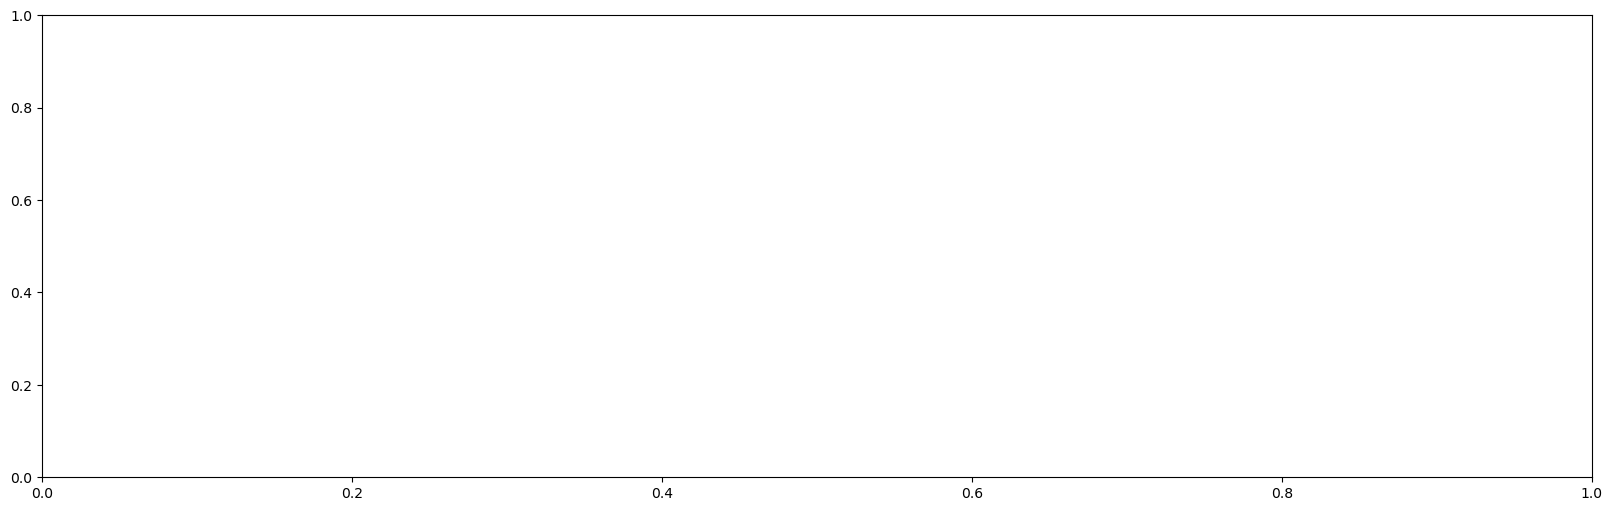

In [29]:
# plot updated smooth with start of season (blue) and peak of season (red)
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = "Mid Weiss G"
ndvi_peak_vals = df_ndvi[df_ndvi[id_col] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_ndvi[df_ndvi[id_col] == plot].groupby('Year').apply(lambda x: x[date_col].iloc[np.argmax(x['NDVI_smooth'])])
df_ndvi[df_ndvi[id_col] == plot].plot.scatter(x=date_col, y='NDVI', ax=ax1, c='grey', s=5)
df_ndvi[df_ndvi[id_col] == plot].plot(x=date_col, y='NDVI_smooth', c='orange', ax=ax1)
df_ndvi[df_ndvi[id_col] == plot].plot(x=date_col, y='NDVI_smooth2', c='green', ax=ax1)
ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
df_sos[df_sos[id_col] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)

In [321]:
df_ndvi

,filename,Date,NDVI,NDVI_smooth,NDVI_smooth2,Year
53,Bill's Home,2019-01-01,NaN,0.195828,0.195312,2019
54,Bill's Home,2019-01-02,NaN,0.196136,0.195346,2019
55,Bill's Home,2019-01-03,NaN,0.196454,0.195397,2019
56,Bill's Home,2019-01-04,NaN,0.196737,0.195462,2019
57,Bill's Home,2019-01-05,NaN,0.196969,0.195542,2019
...,...,...,...,...,...,...
14976,Mid Weiss G,2021-12-27,NaN,0.219003,0.219158,2021
14977,Mid Weiss G,2021-12-28,NaN,0.218254,0.218473,2021
14978,Mid Weiss G,2021-12-29,NaN,0.217506,0.217710,2021
14979,Mid Weiss G,2021-12-30,NaN,0.216758,0.216955,2021


In [322]:
df_ndvi = df_ndvi[df_ndvi.apply(lambda x: '_'.join([str(x['Year']), x[id_col]]), 
                      axis=1).isin(df_sos.apply(lambda x: '_'.join([str(x['Year']), x[id_col]]), axis=1))].copy()

In [324]:
# get average from two smooths, weighted by distance to SOS and peak NDVI 
ndvi_smooth_avg = df_ndvi.groupby(id_col).progress_apply(lambda x: weighted_ndvi(x['NDVI_smooth'], 
                                                                  x['NDVI_smooth2'],
                                                                  x[date_col]))
df_ndvi['NDVI_smooth_avg'] = ndvi_smooth_avg.droplevel(list(np.arange(ndvi_smooth_avg.index.nlevels-1)))

100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


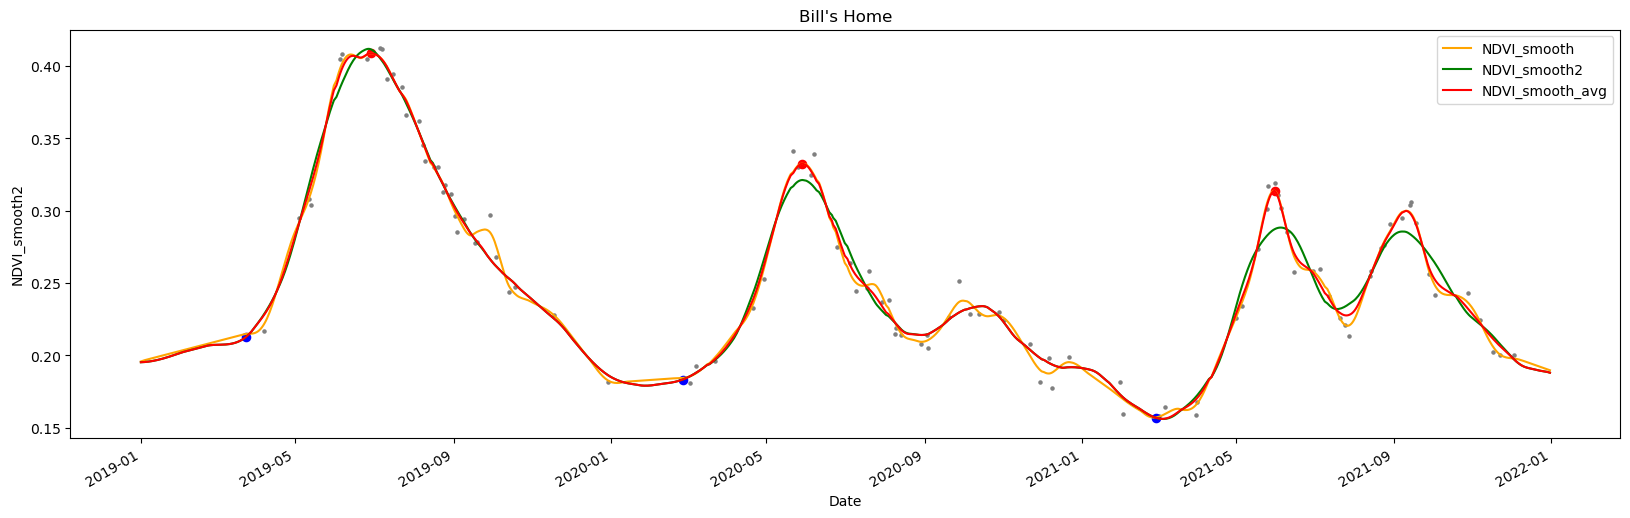

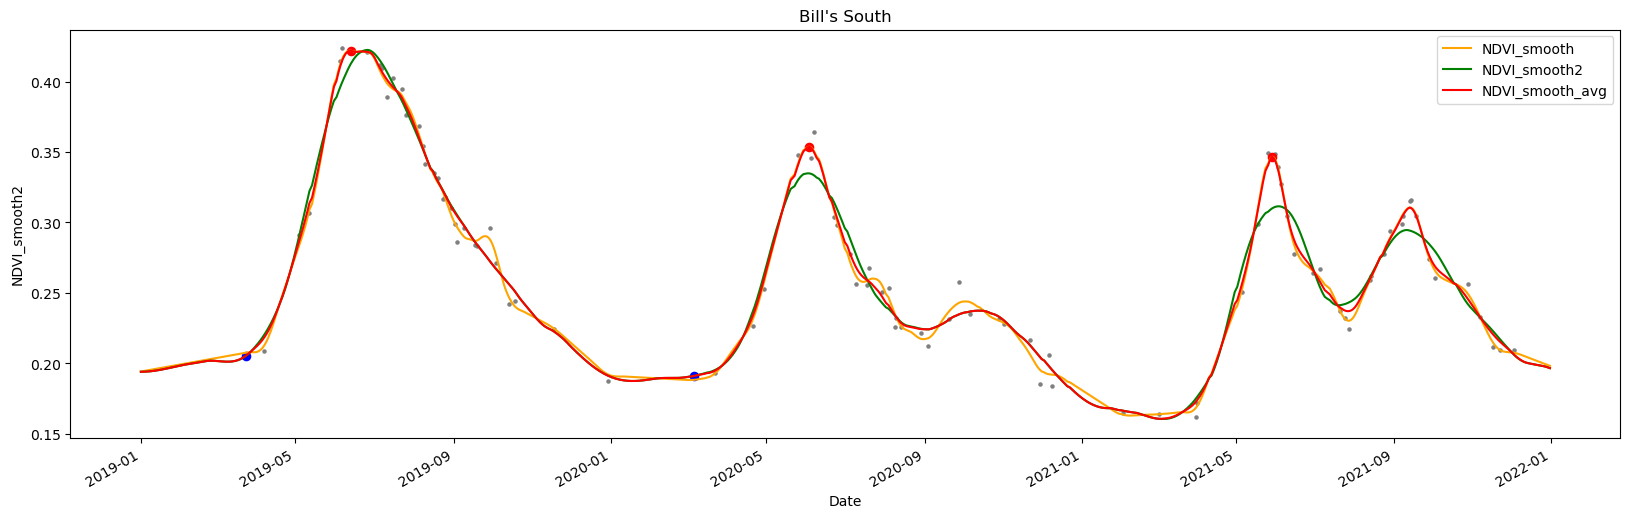

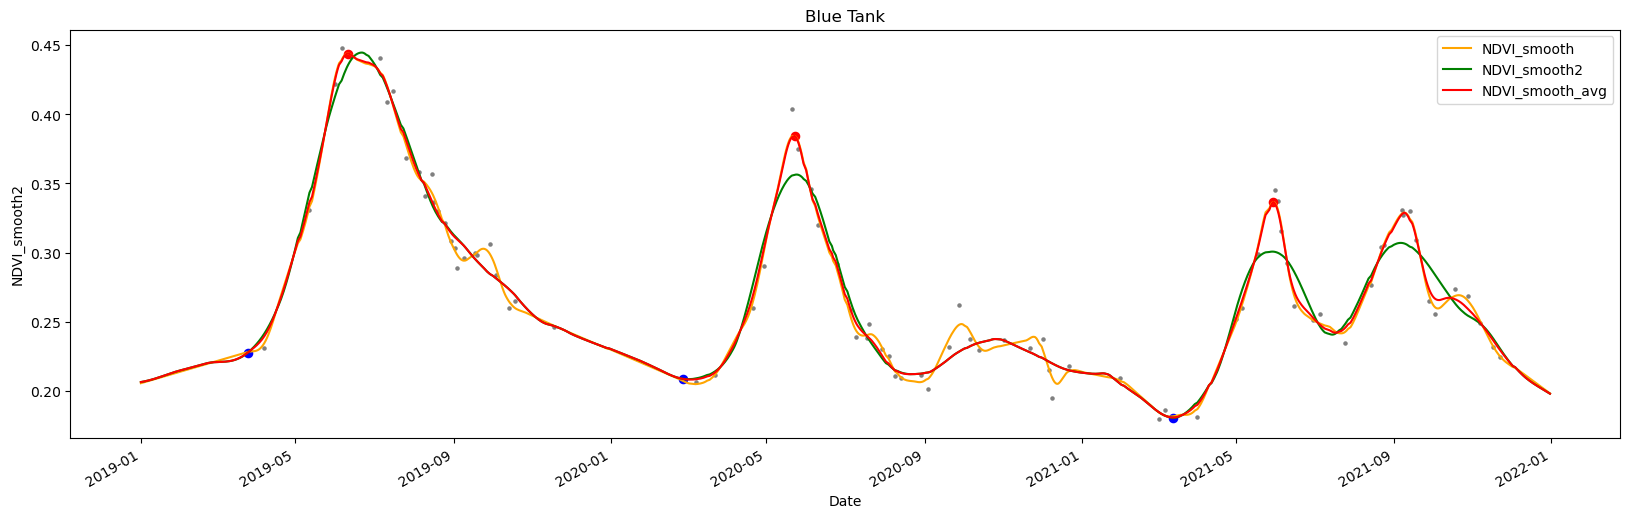

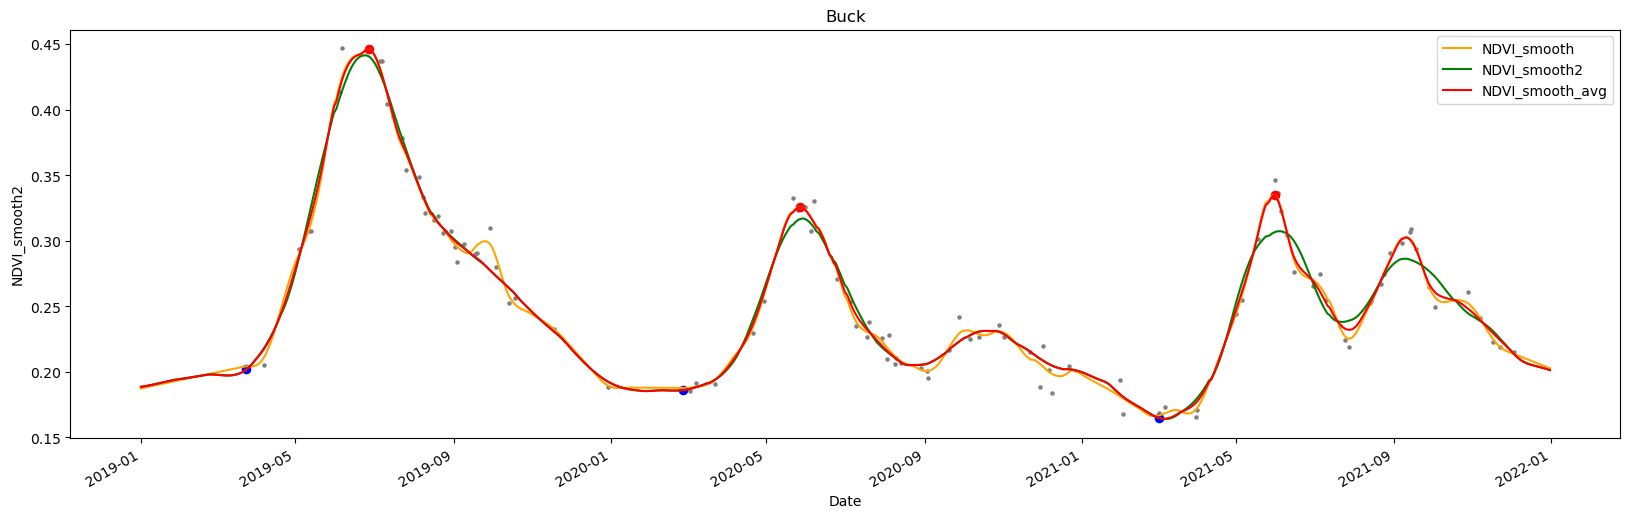

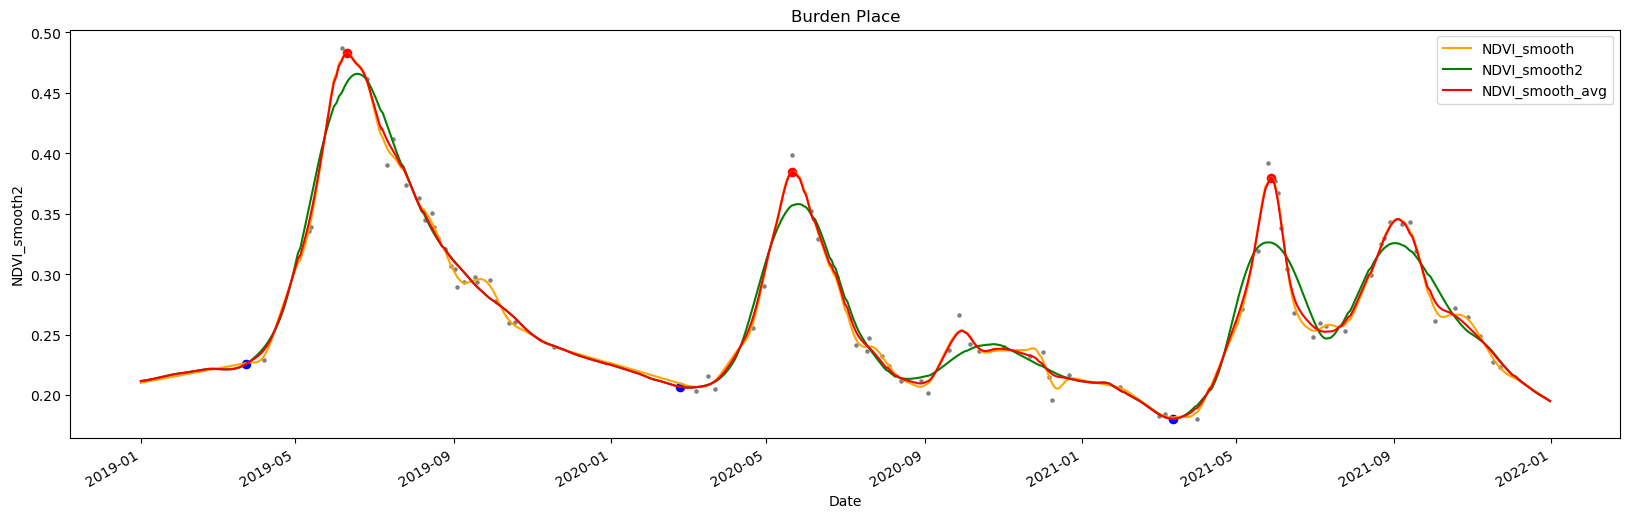

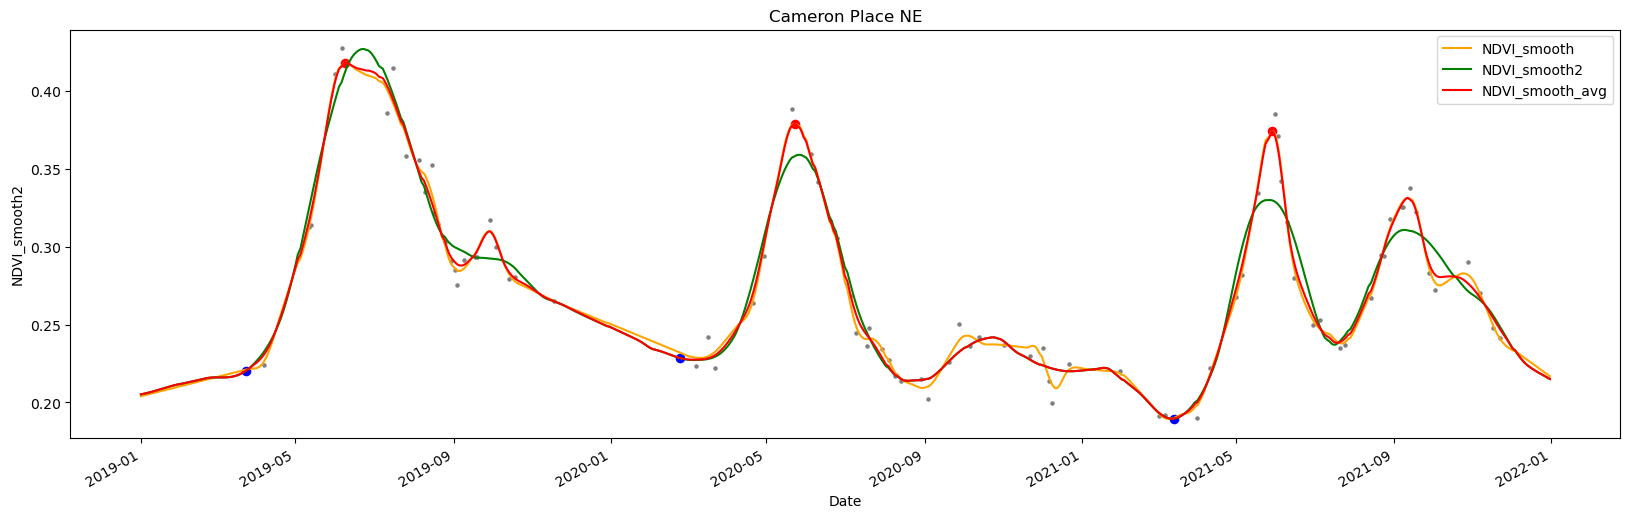

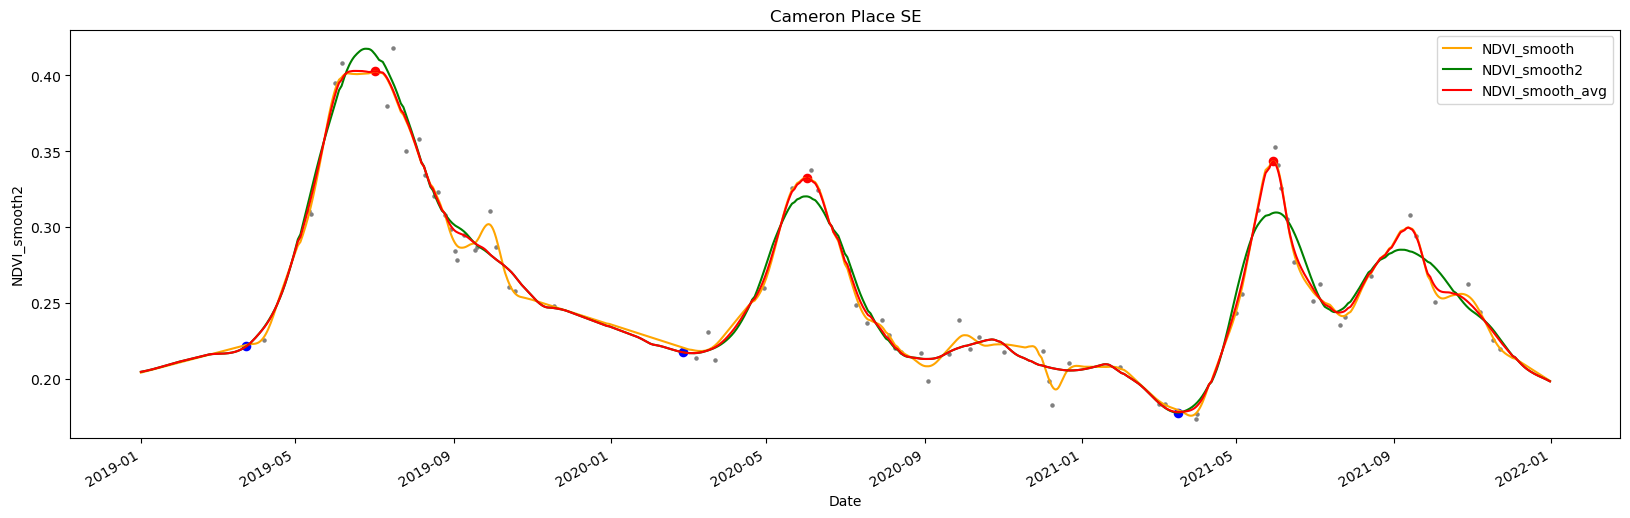

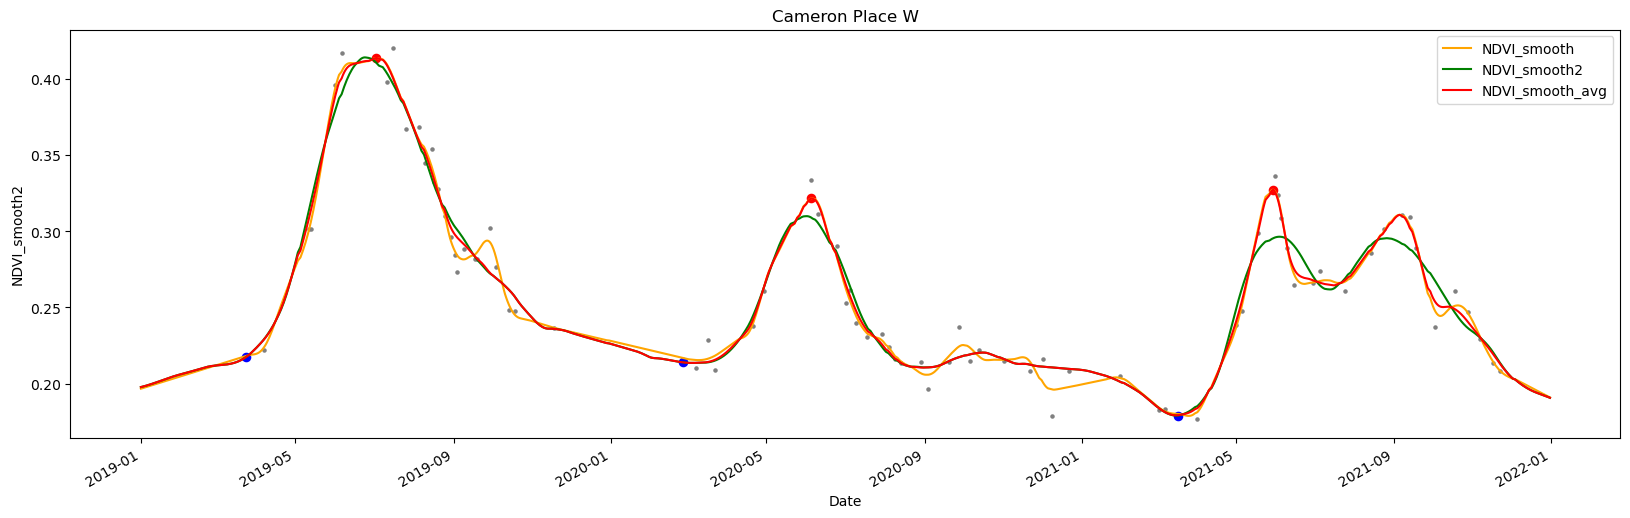

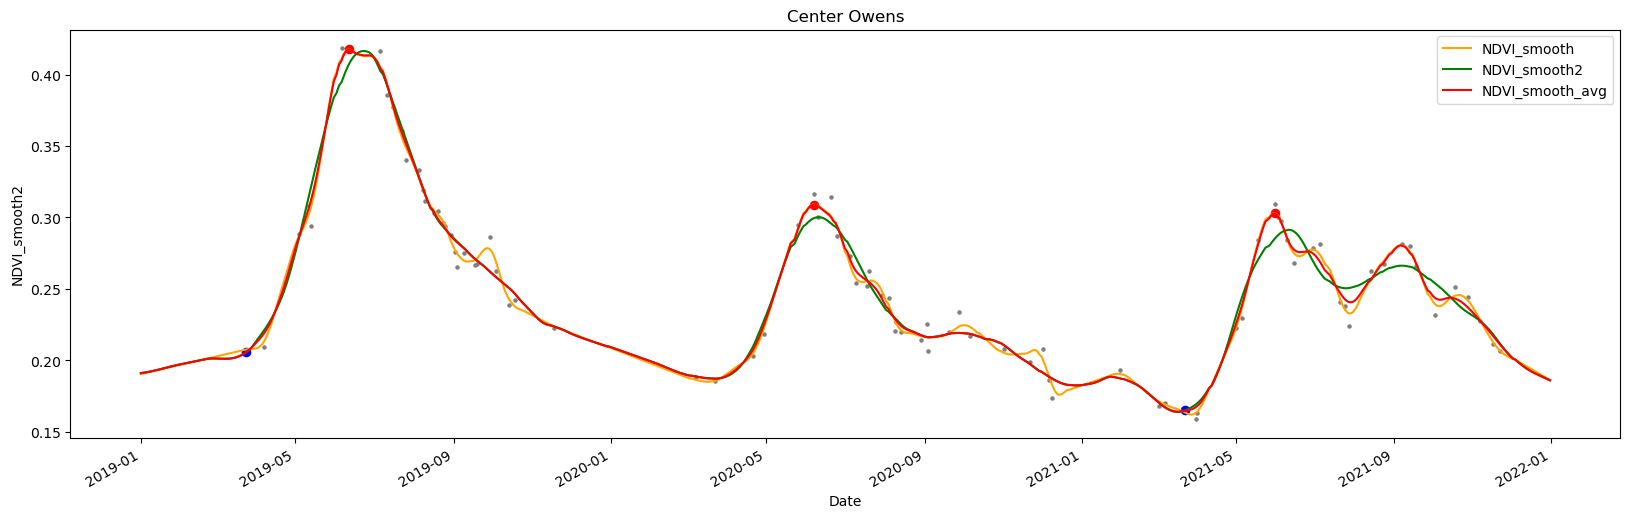

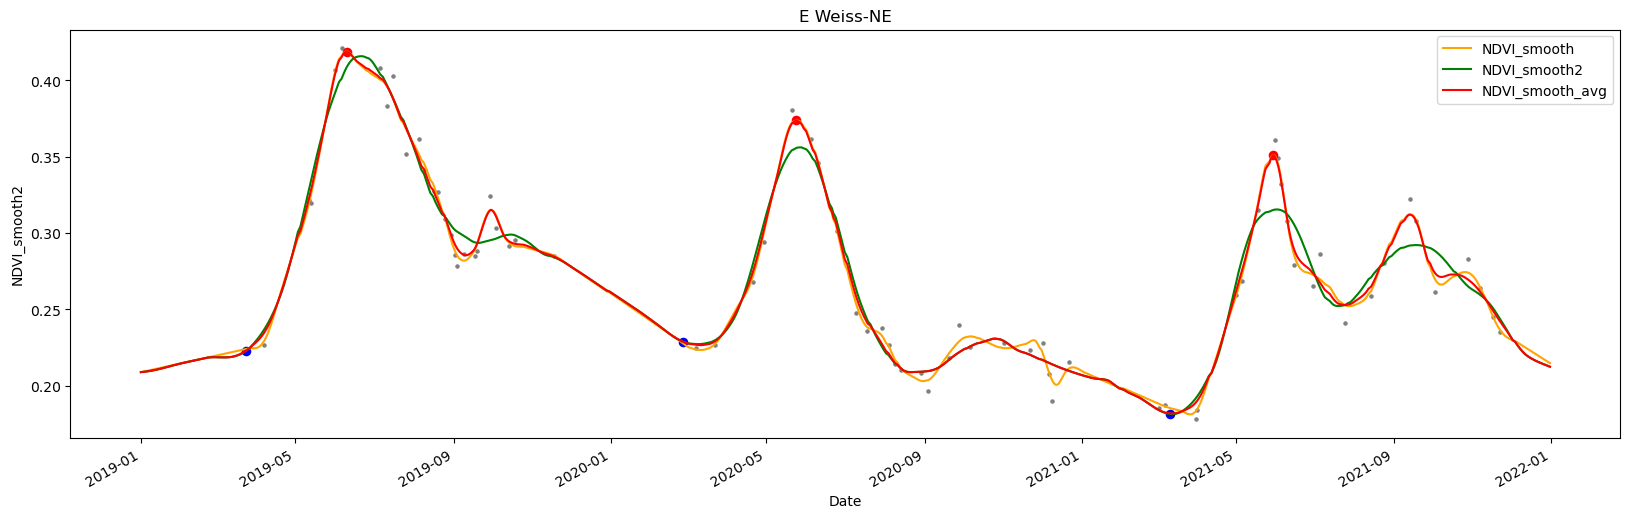

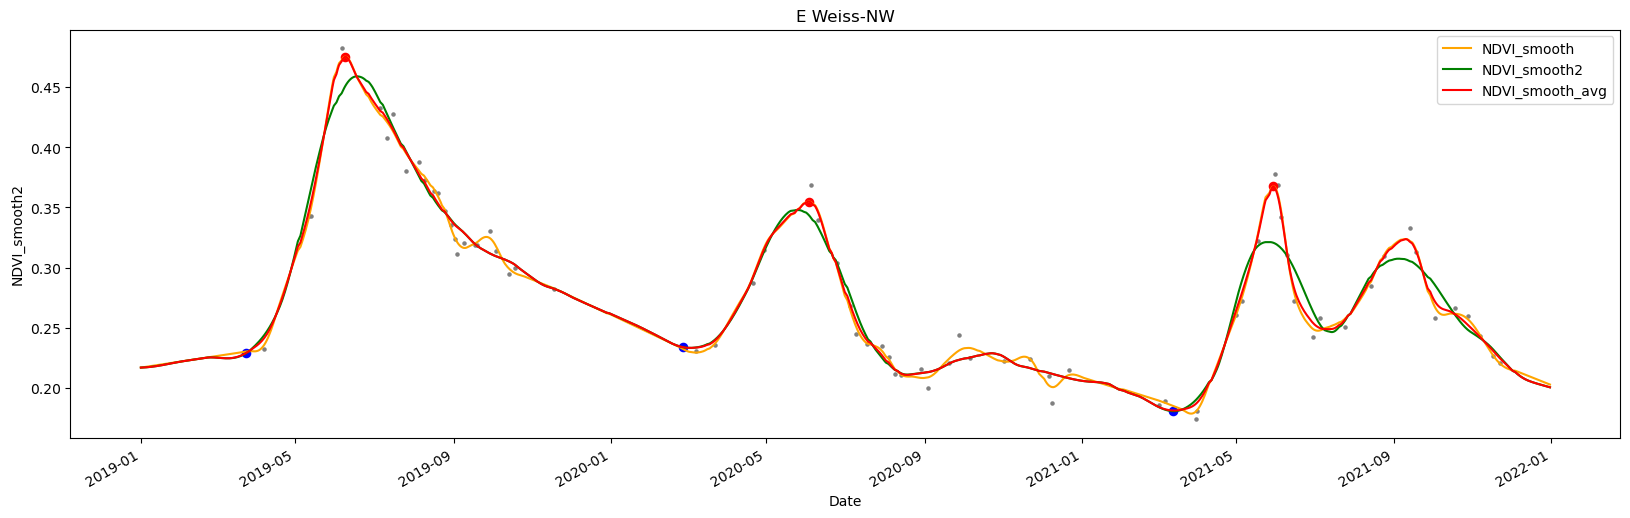

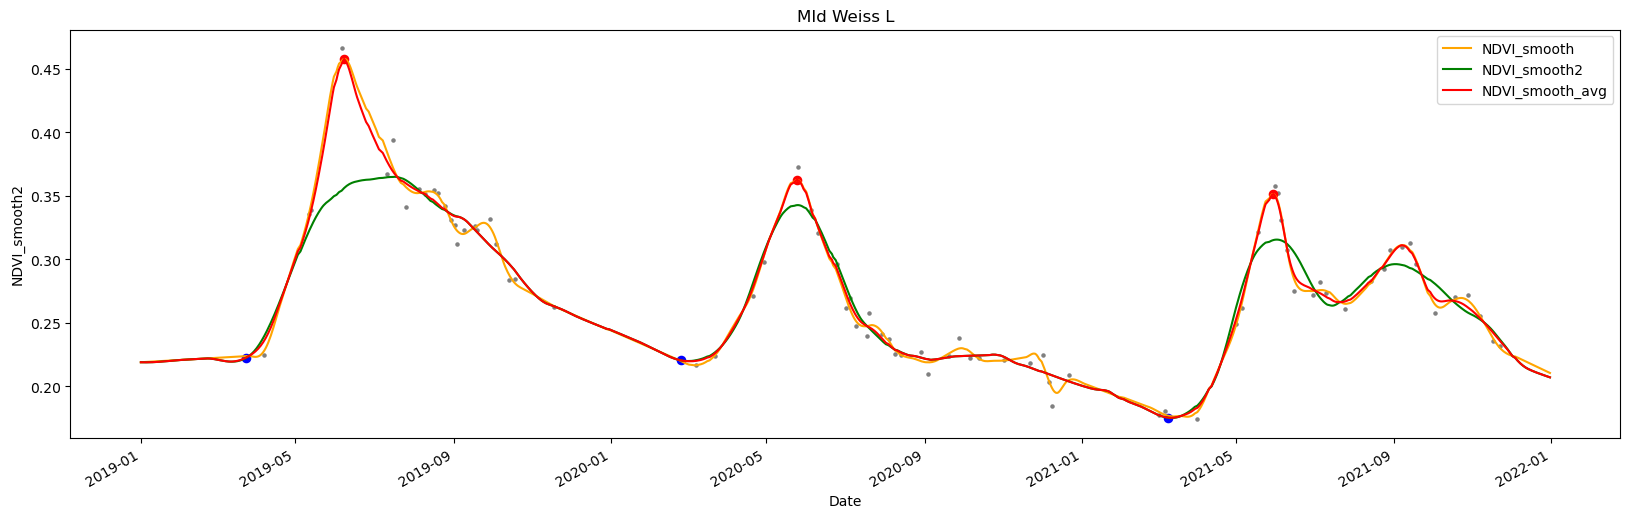

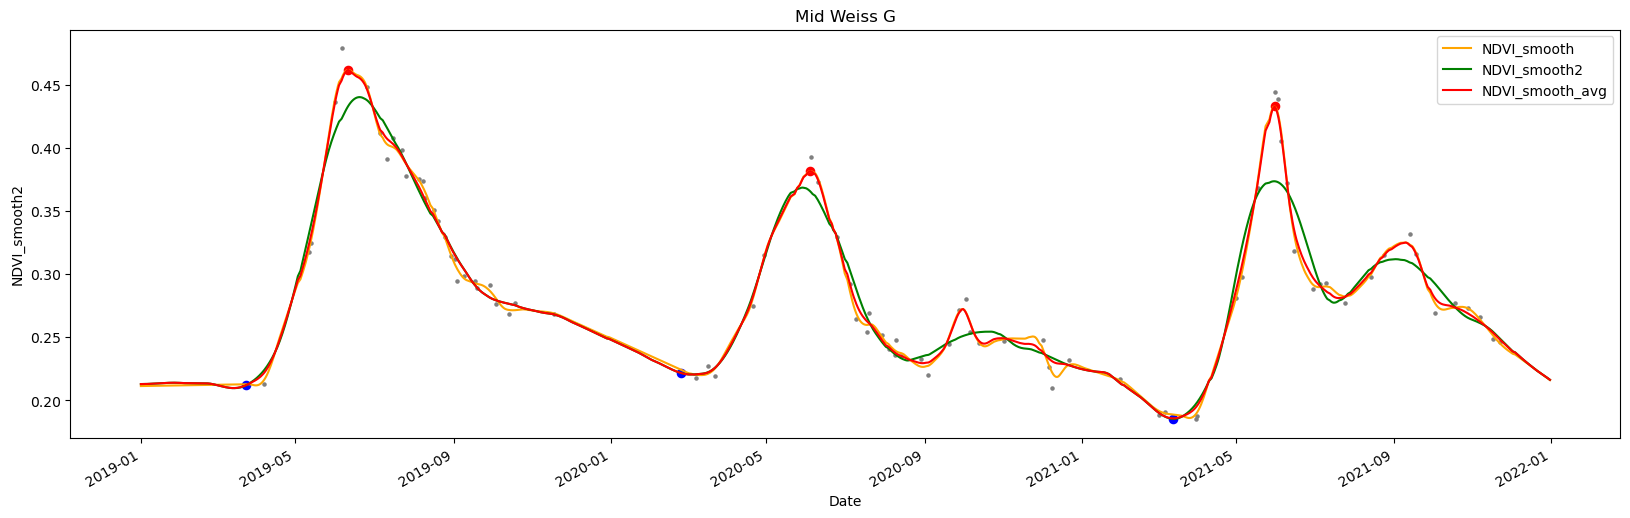

In [325]:
for plot in df_ndvi[id_col].unique():
    fig, ax1 = plt.subplots(figsize=(20, 6))
    ndvi_peak_vals = df_ndvi[df_ndvi[id_col] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
    ndvi_peak_dates = df_ndvi[df_ndvi[id_col] == plot].groupby('Year').apply(lambda x: x[date_col].iloc[np.argmax(x['NDVI_smooth'])])
    df_ndvi[df_ndvi[id_col] == plot].plot.scatter(x=date_col, y='NDVI', ax=ax1, c='grey', s=5)
    df_ndvi[df_ndvi[id_col] == plot].plot(x=date_col, y='NDVI_smooth', c='orange', ax=ax1)
    df_ndvi[df_ndvi[id_col] == plot].plot(x=date_col, y='NDVI_smooth2', c='green', ax=ax1)
    ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
    df_sos[df_sos[id_col] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)
    df_ndvi[df_ndvi[id_col] == plot].plot(x=date_col, y='NDVI_smooth_avg', ax=ax1, c='red')
    plt.title(plot)
    plt.show()

In [333]:
df_ndvi['NDVI_d30'] = df_ndvi.groupby(id_col)['NDVI_smooth_avg'].transform(lambda x: x.diff().rolling(30).mean())

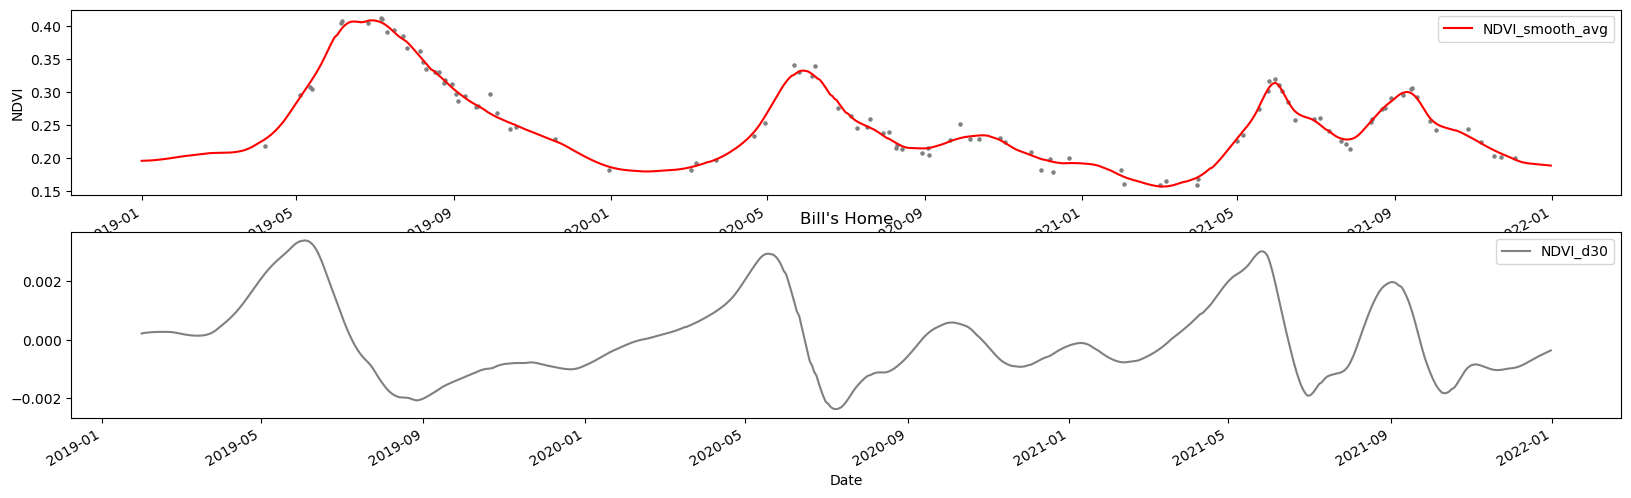

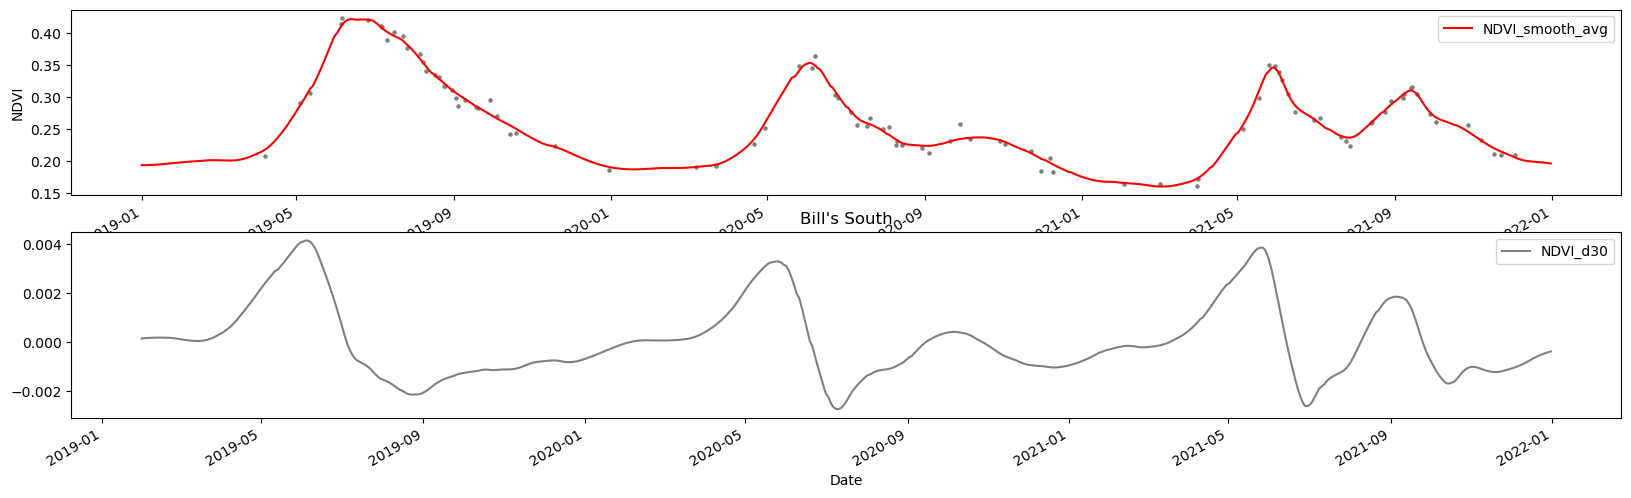

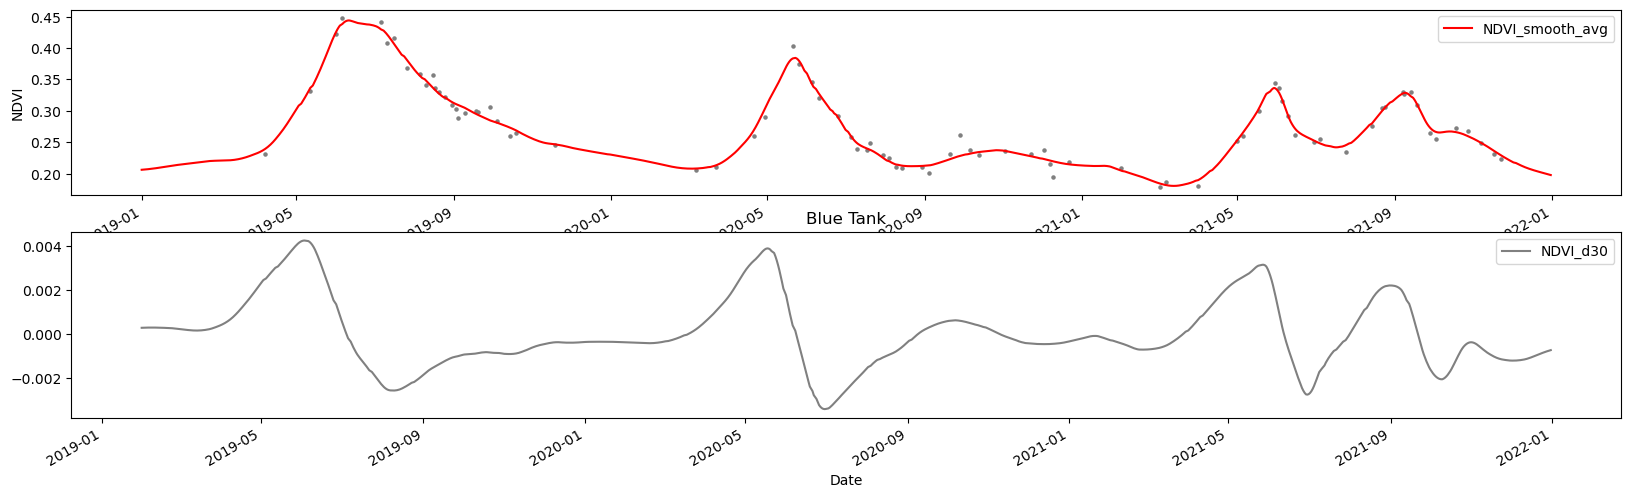

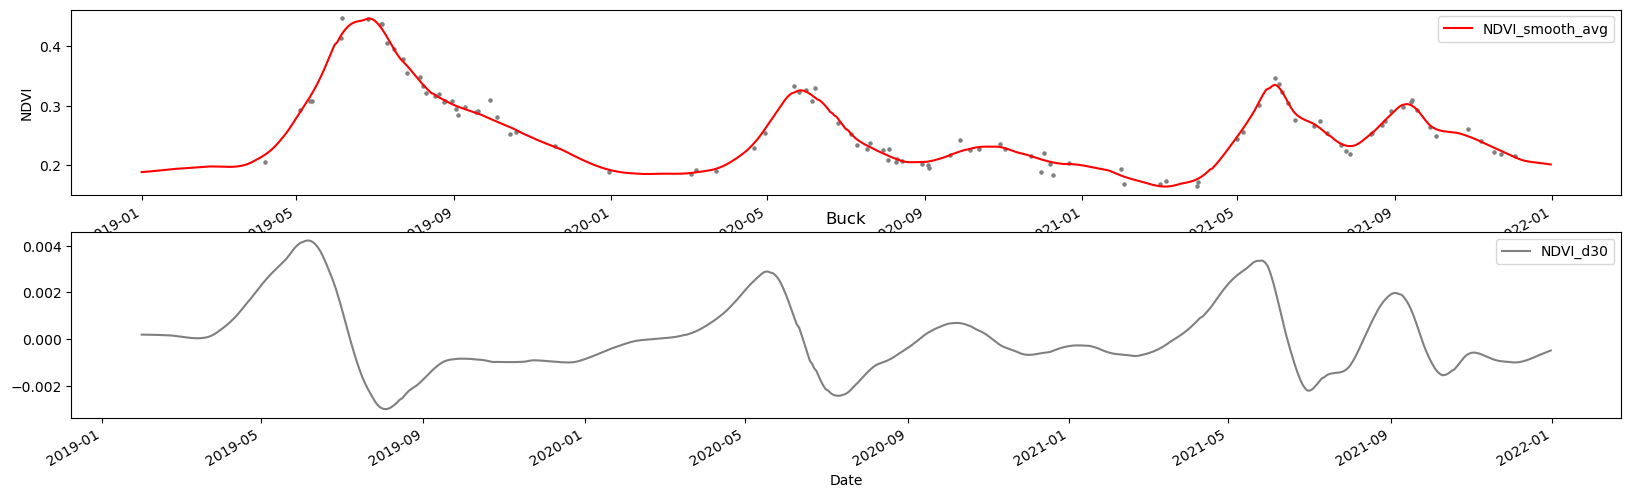

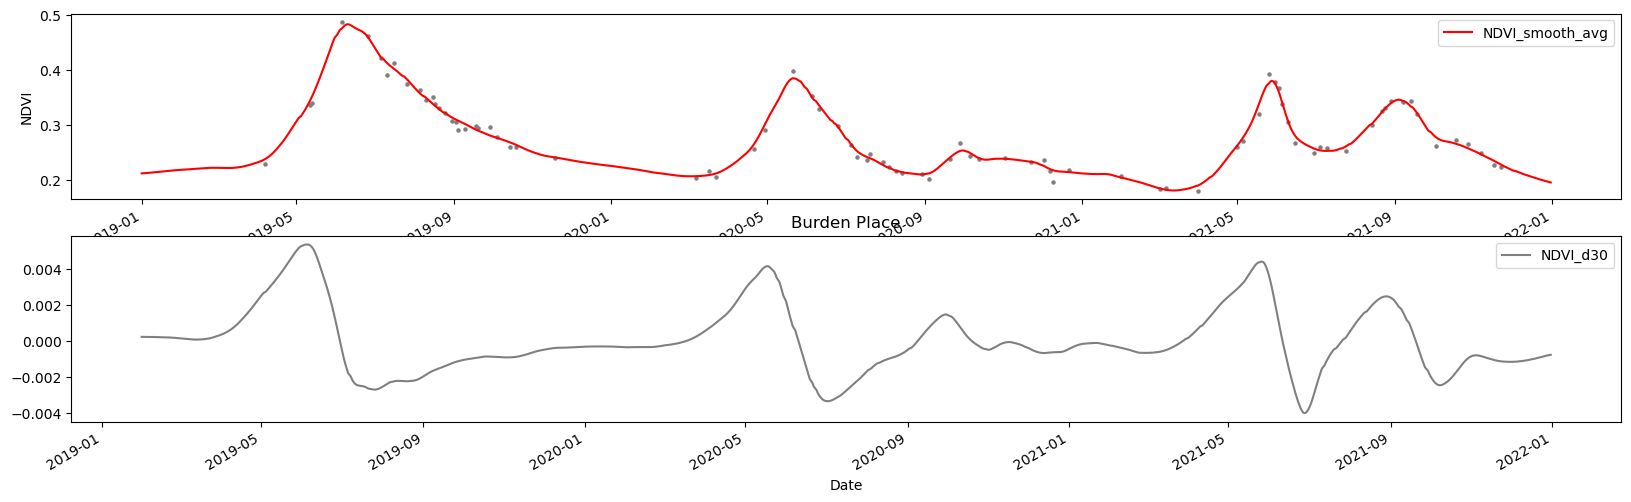

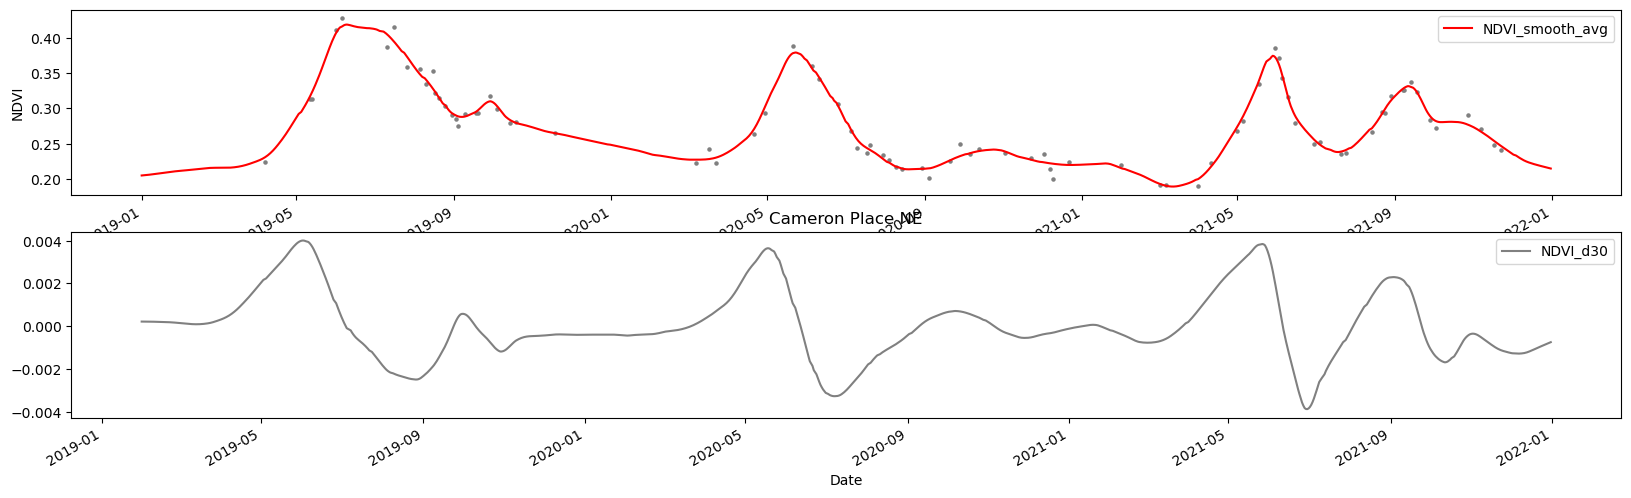

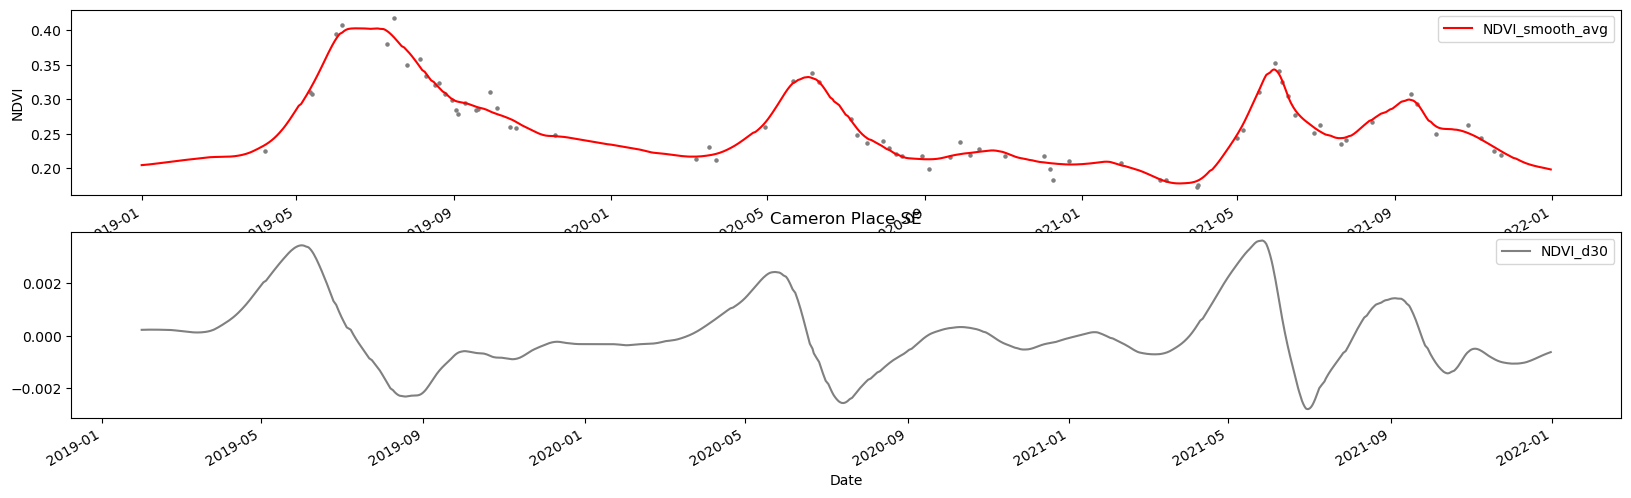

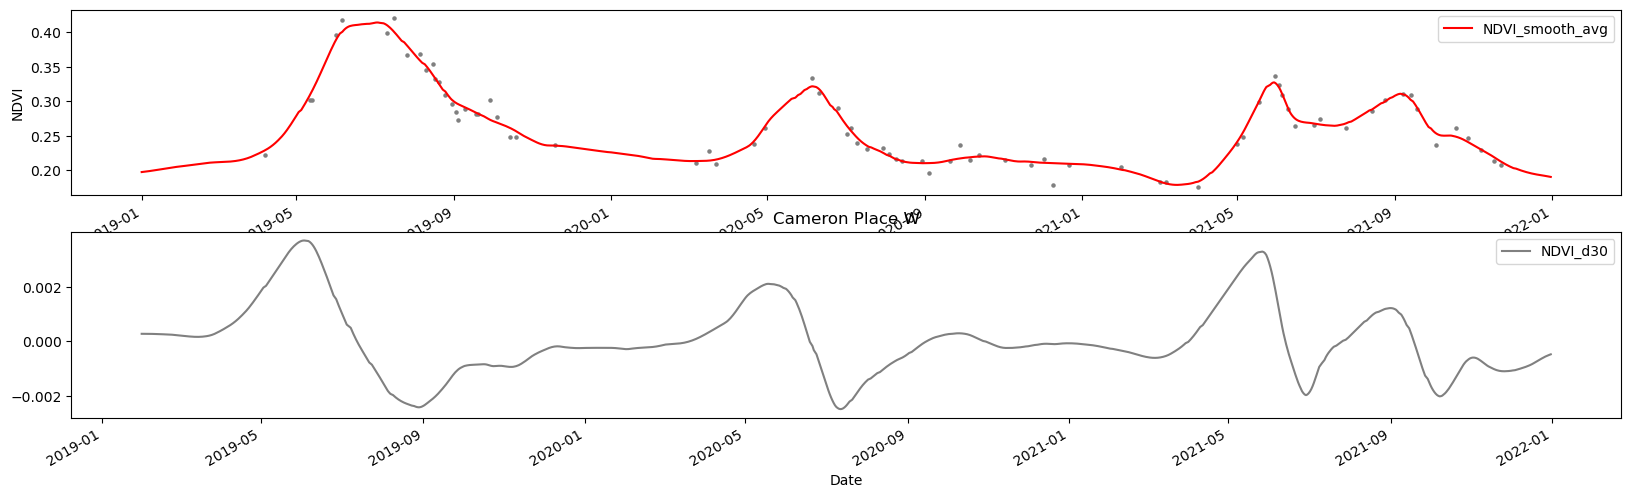

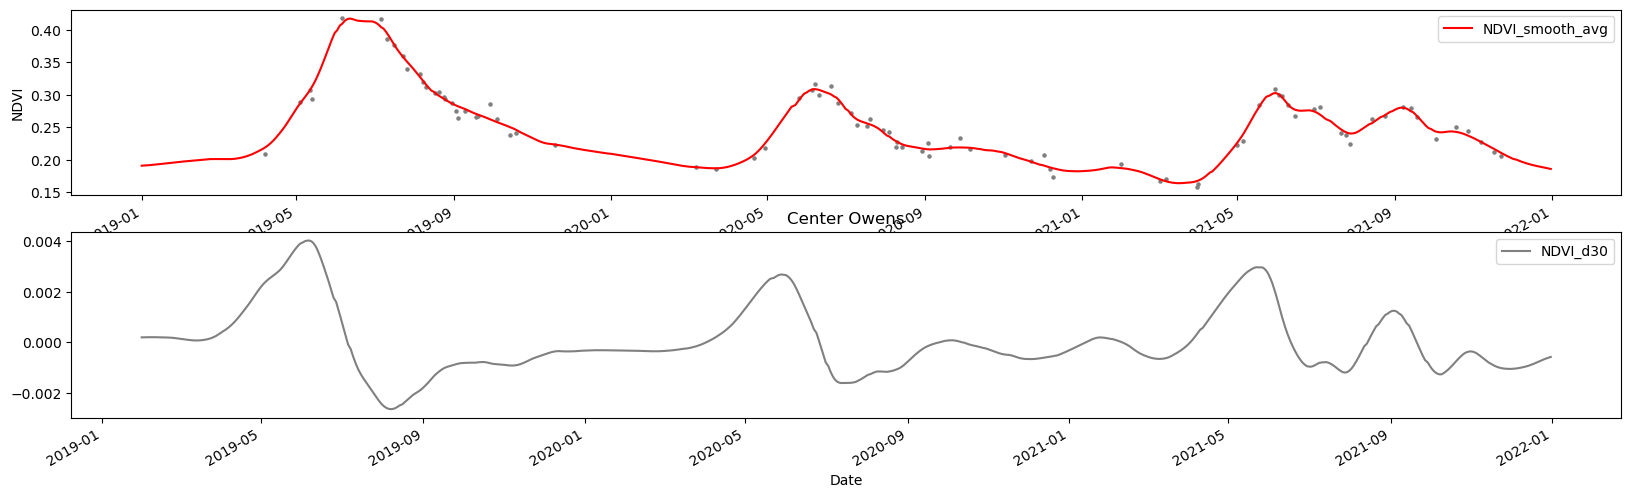

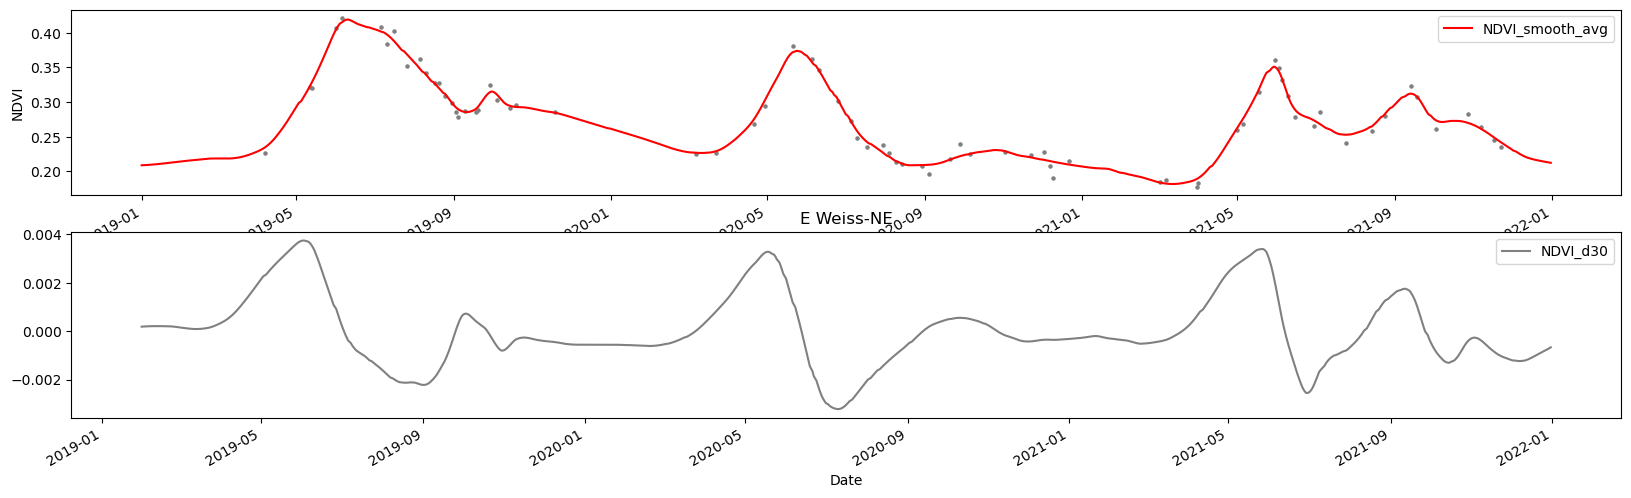

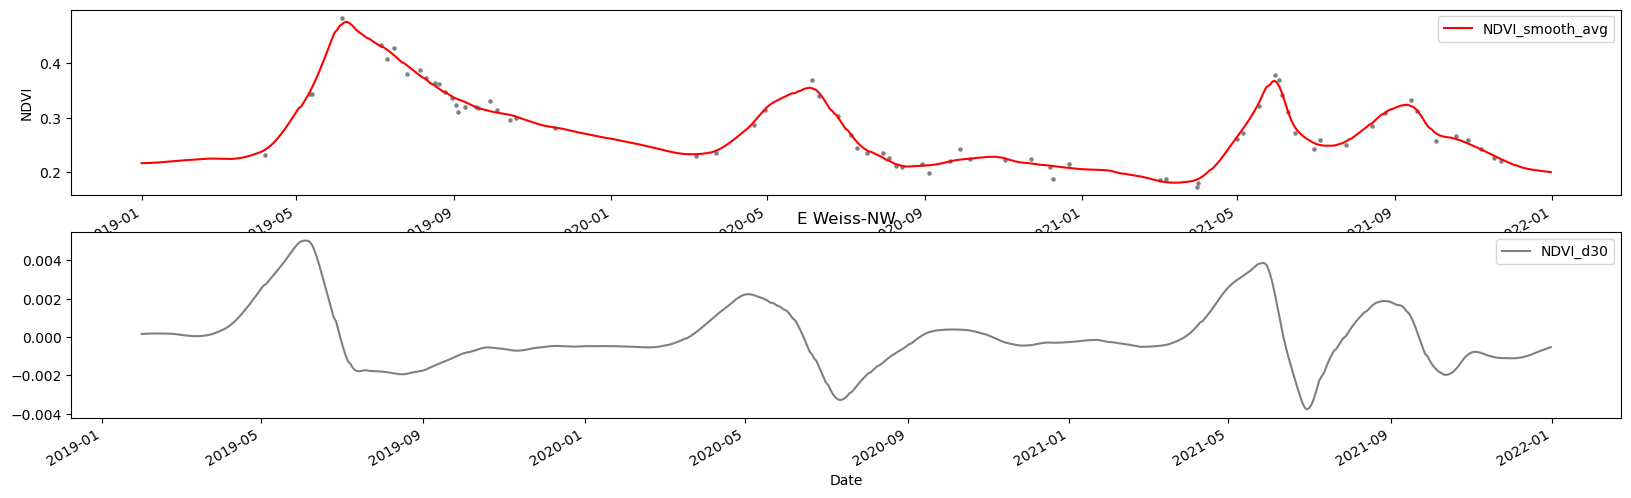

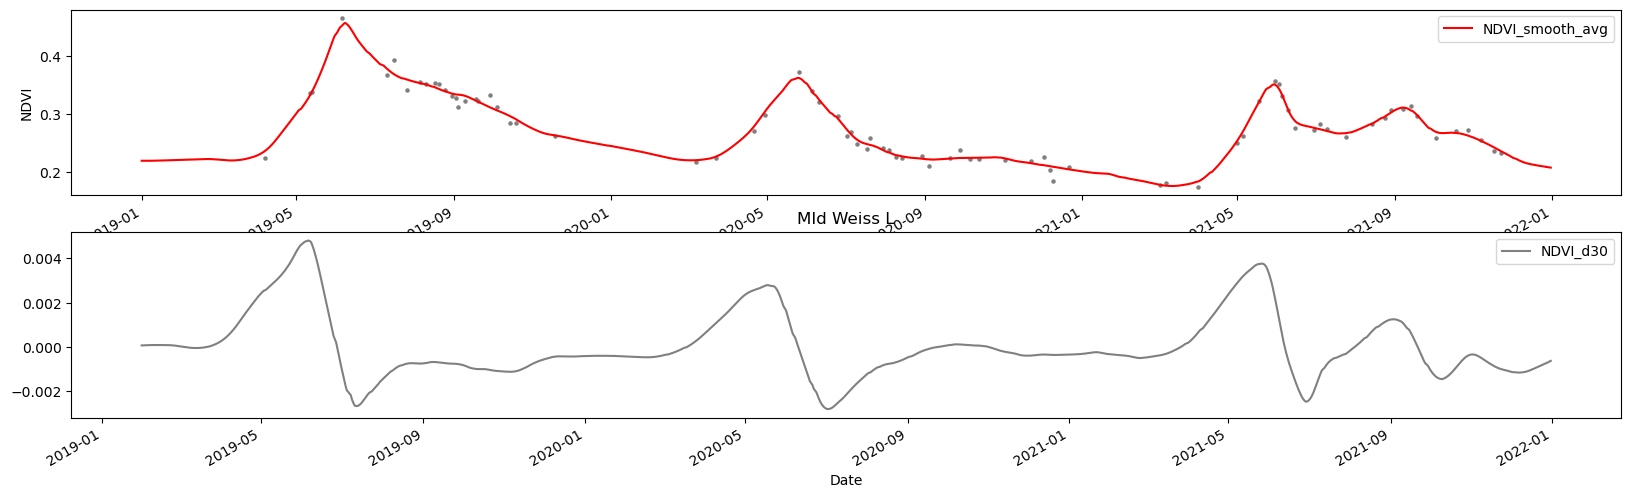

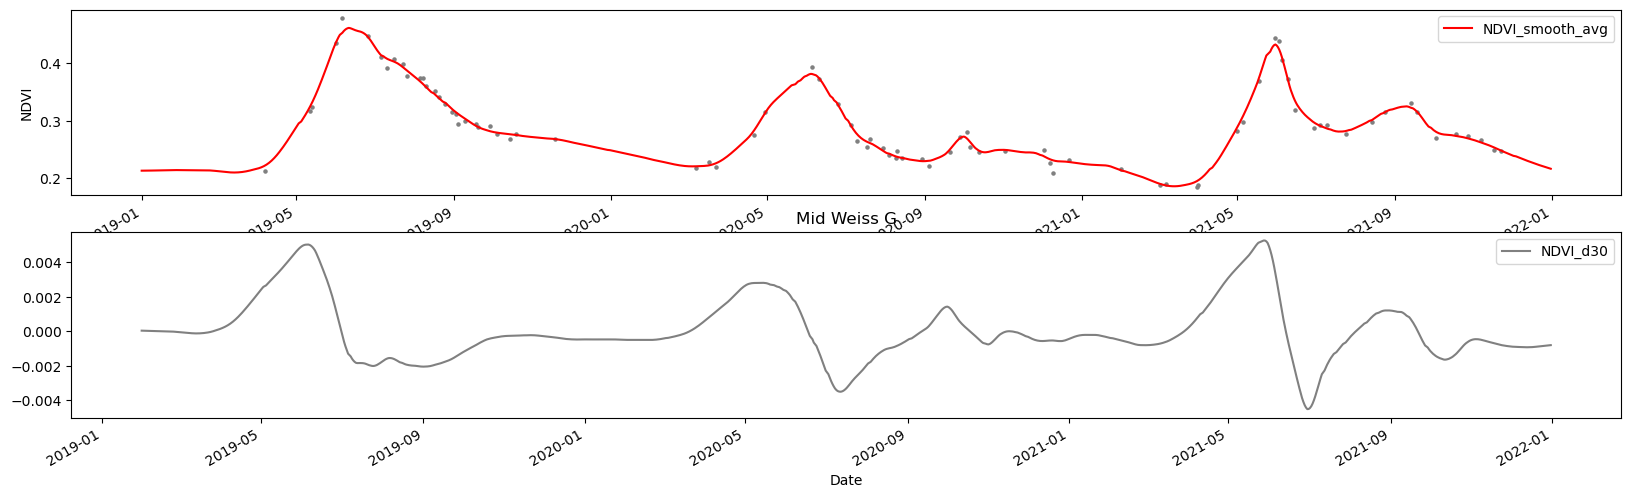

In [334]:
for plot in df_ndvi[id_col].unique():
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
    df_ndvi[df_ndvi[id_col] == plot].plot.scatter(x=date_col, y='NDVI', ax=ax[0], c='grey', s=5)
    df_ndvi[df_ndvi[id_col] == plot].plot(x=date_col, y='NDVI_smooth_avg', ax=ax[0], c='red')
    df_ndvi[df_ndvi[id_col] == plot].plot(x=date_col, y='NDVI_d30', ax=ax[1], c='grey')
    plt.title(plot)
    plt.show()

In [49]:
df_ndvi.to_csv(outPATH_ndvi, index=False)

In [52]:
df_sos.drop(columns=[date_col]).to_csv(outPATH_sos, index=False)